# Bootstrap analysis of helmet safety data

<img src="https://risk-engineering.org/static/img/logo-RE.png" width="100" alt="" style="float:right;margin:15px;">

This notebook is an element of the [risk-engineering.org courseware](https://risk-engineering.org/). It can be distributed under the terms of the [Creative Commons Attribution-ShareAlike licence](https://creativecommons.org/licenses/by-sa/4.0/).

Author: Eric Marsden <eric.marsden@risk-engineering.org>. 

---

This notebook contains an short case study using Python and SciPy to analyze some online data on the safety performance of different helmet technologies. It includes regression analysis to estimate the impact of technology on performance, and **bootstrap resampling** to obtain an estimate despite a small sample size. See the [associated course materials](https://risk-engineering.org/statistical-modelling/) for background information and to download this content as a Jupyter notebook.

In [1]:
import numpy
import scipy.stats
import pandas
import matplotlib.pyplot as plt
plt.style.use("bmh")
%config InlineBackend.figure_formats=["svg"]

**Acknowledgement**. This notebook is heavily inspired by [a blog post by Daniel Phadley](https://www.danielphadley.com/bootstrap_tutto/) where the analysis is undertaken in R. 

We are going to analyze [test data produced by researchers at Virginia Tech](https://helmet.beam.vt.edu/) (a public university in the US state of Virginia). The researchers run impact tests on a range of helmets and assess the likelihood of sustaining a concussion from different types of impacts. From this, they attribute a performance score. This type of testing, and of course publication of the results to help consumers make an informed choice, is very important to encourage manufacturers to improve the safety performance of their products; congratulations to the Virginia Tech researchers. 

Their data is published on a web page, but isn’t available in a convenient format that we can use directly from Python, such as CSV or JSON. We’re going to have to “scrape” the data from the web page, which means download the web page content and use some simple parsing techniques to extract the data. This is a fairly common activity for data analysts, because quite often people who generate interesting data don’t think of, or sometimes don’t want to, make it available as a dataset. 

**Note**: this notebook was updated in April 2022 because the content of the web page was changed, so the scraping code had to be updated. A frequent and annoying problem when web scraping...

## Scraping data from web page

Techniques for scraping data from the web are fairly well documented online. They require a little technical knowledge of HTML parsing and a little Python text processing. 

In [2]:
import requests
import re

page = requests.get("https://helmet.beam.vt.edu/js/bicycleData.js")
js = page.content
if not js.startswith(b"var bicycleDataRaw ="):
    raise RuntimeError("HTML has changed, need to update the parser!")
js = js[21:-1]
# we use a regexp to convert the Javascript array containing the data
# into the JSON format that is easily parsed from Python. 
json_bytes = re.sub(b'\\s([a-z]+):\\s', b'"\\1":', js) + b"]"
helmets = pandas.read_json(json_bytes)
len(helmets)

148

In [3]:
helmets.head()

,brand,model,score,rating,cost,style,date,photo,certifications,low,high
0,Specialized,Tactic 4 MIPS,8.55,5,$110,Mountain,2021,specialized-tactic-4-mips.jpg,CPSC,2.019,6.535
1,Sweet Protection,Trailblazer MIPS,8.69,5,$180,Mountain,2021,sweet-protection-trailblazer-mips.jpg,CPSC,2.031,6.655
2,Specialized,Mode MIPS,8.80,5,$120,Urban,2021,specialized-mode-mips.jpg,CPSC,2.423,6.379
3,Fox,Dropframe Pro MIPS,8.85,5,$200,Mountain,2018,fox-dropframe-pro-mips.jpg,CPSC,2.298,6.553
4,Giant,Rev Comp MIPS,9.13,5,$65,Road,2021,giant-rev-comp-mips.jpg,CPSC,2.202,6.922


The cost is expressed in an inconvenient format with a prefixed `$` sign; we convert that to a numerical field. Also drop a column that we don't need in our analysis.

In [4]:
helmets["price"] = helmets["cost"].map(lambda s: float(s[1:]))
helmets.drop(columns=["photo"], inplace=True)

In [5]:
helmets.head()

,brand,model,score,rating,cost,style,date,certifications,low,high,price
0,Specialized,Tactic 4 MIPS,8.55,5,$110,Mountain,2021,CPSC,2.019,6.535,110.0
1,Sweet Protection,Trailblazer MIPS,8.69,5,$180,Mountain,2021,CPSC,2.031,6.655,180.0
2,Specialized,Mode MIPS,8.80,5,$120,Urban,2021,CPSC,2.423,6.379,120.0
3,Fox,Dropframe Pro MIPS,8.85,5,$200,Mountain,2018,CPSC,2.298,6.553,200.0
4,Giant,Rev Comp MIPS,9.13,5,$65,Road,2021,CPSC,2.202,6.922,65.0


Let's explore our dataset a little, looking at the distribution of helmet price and of performance score.

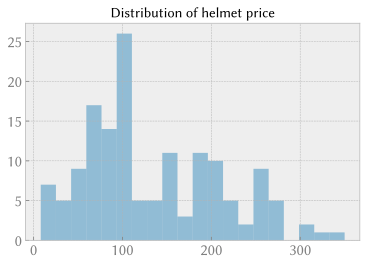

In [6]:
plt.hist(helmets.price, bins=20, alpha=0.5)
plt.title("Distribution of helmet price");

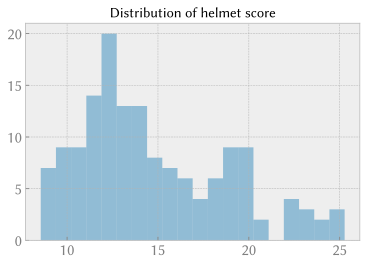

In [7]:
plt.hist(helmets.score, bins=20, alpha=0.5)
plt.title("Distribution of helmet score");

We can examine whether there is a correlation between helmet price and performance score. 

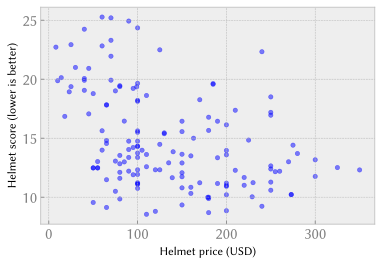

In [8]:
helmets.plot("price", "score", "scatter", alpha=0.5)
plt.xlabel("Helmet price (USD)")
plt.ylabel("Helmet score (lower is better)");

## Analyze impact of helmet technology

The helmets in this dataset use three design technologies:

- MIPS or [Multi-directional Impact Protection System](https://www.bicycleroots.com/blog/mips-helmet-technology-what-it-is-and-why-you-need-it/), which reduces the harmful rotational motion generated on impact which would otherwise be transferred to the brain

- [WaveCel](https://wavecel.com/), a shock-absorbing material with a collapsible cellular structure. This technology is only available from a single manufacturer, so few helmets are available. 

- conventional impact-absorbing materials, with a certification provided by the US Consumer Product Safety Commission (all helmets sold in the USA must meet this certification)

There is some commercial and technical squabbling about the relative performance of these design approaches, so it’s interesting to see what the test data says. 

The helmet technology is not represented explicitly in our dataset, but it’s encoded in the helmet name. 

In [9]:
def technology_from_model(name: str):
    if "MIPS" in name: return "MIPS"
    if "WaveCel" in name: return "WaveCel"
    return "conventional"

We can add a column to the dataset with the design technology used. 

In [10]:
helmets["technology"] = helmets["model"].apply(technology_from_model)
helmets.head(20)

,brand,model,score,rating,cost,style,date,certifications,low,high,price,technology
0,Specialized,Tactic 4 MIPS,8.55,5,$110,Mountain,2021,CPSC,2.019,6.535,110.0,MIPS
1,Sweet Protection,Trailblazer MIPS,8.69,5,$180,Mountain,2021,CPSC,2.031,6.655,180.0,MIPS
2,Specialized,Mode MIPS,8.80,5,$120,Urban,2021,CPSC,2.423,6.379,120.0,MIPS
3,Fox,Dropframe Pro MIPS,8.85,5,$200,Mountain,2018,CPSC,2.298,6.553,200.0,MIPS
4,Giant,Rev Comp MIPS,9.13,5,$65,Road,2021,CPSC,2.202,6.922,65.0,MIPS
5,Lazer,G1 MIPS,9.23,5,$240,Road,2020,CPSC,2.396,6.830,240.0,MIPS
6,Bontrager,Rally MIPS,9.34,5,$150,Mountain,2019,CPSC,2.335,7.010,150.0,MIPS
7,Specialized,Align II MIPS,9.55,5,$50,Multi-sport,2020,CPSC,2.954,6.600,50.0,MIPS
8,Lazer,Tonic MIPS,9.85,5,$80,Road,2021,CPSC,2.557,7.290,80.0,MIPS
9,Troy Lee Designs,A2 MIPS Decoy,9.99,5,$179,Mountain,2019,CPSC,2.523,7.464,179.0,MIPS


Let’s examine a few plots of this dataset to get a feel for the impact of helmet technology on performance score, and see whether there’s a relationship between price and performance. 

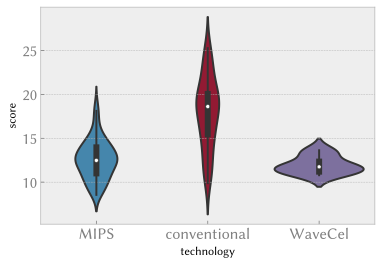

In [11]:
import seaborn as sns

sns.violinplot(x="technology", y="score", data=helmets);

A violin plot, shown above, is an enhanced version of the traditional boxplot, or “box-and-whisker” plot. 

This plot shows that MIPS and WaveCel are clearly scoring better (remember that lower scores indicate better safety performance) than conventional helmets, but it isn’t very helpful in determining whether MIPS performs better than WaveCel (the median points for the two categories, shown by the white dot in the violin plot, are very similar). We'll undertake a more sophisticated analysis below to help resolve this question.

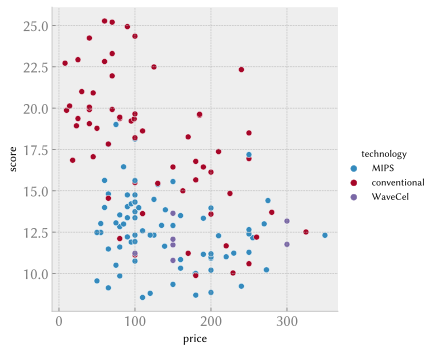

In [12]:
sns.relplot(x="price", y="score", hue="technology", data=helmets);

Note how the plot above encodes information on three dimensions of our dataset, the price and score but also the technology as the color of the points. This plot highlights the fact that we have few helmets in our dataset using the WaveCel technology.

We can also check whether the type of helmet (targeting road use, urban use or mountainbike use) is correlated with performance.

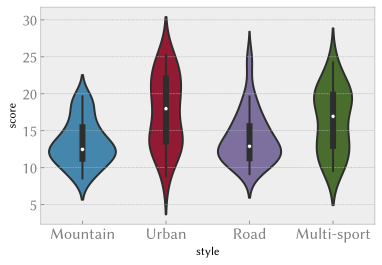

In [13]:
sns.violinplot(x="style", y="score", data=helmets);

## Regression analysis

We will run a regression analysis to analyze the comparative impact of helmet technology (MIPS or WaveCel) on performance score. To do this, we need to add columns to the Pandas dataframe indicating whether each technology is present. 

In [14]:
# generate extra boolean columns that indicate whether MIPS and WaveCell technologies
# are present
helmets["has_mips"] = helmets["technology"].apply(lambda t: t == "MIPS")
helmets["has_wavecel"] = helmets["technology"].apply(lambda t: t == "WaveCel")
helmets.head(20)

,brand,model,score,rating,cost,style,date,certifications,low,high,price,technology,has_mips,has_wavecel
0,Specialized,Tactic 4 MIPS,8.55,5,$110,Mountain,2021,CPSC,2.019,6.535,110.0,MIPS,True,False
1,Sweet Protection,Trailblazer MIPS,8.69,5,$180,Mountain,2021,CPSC,2.031,6.655,180.0,MIPS,True,False
2,Specialized,Mode MIPS,8.80,5,$120,Urban,2021,CPSC,2.423,6.379,120.0,MIPS,True,False
3,Fox,Dropframe Pro MIPS,8.85,5,$200,Mountain,2018,CPSC,2.298,6.553,200.0,MIPS,True,False
4,Giant,Rev Comp MIPS,9.13,5,$65,Road,2021,CPSC,2.202,6.922,65.0,MIPS,True,False
5,Lazer,G1 MIPS,9.23,5,$240,Road,2020,CPSC,2.396,6.830,240.0,MIPS,True,False
6,Bontrager,Rally MIPS,9.34,5,$150,Mountain,2019,CPSC,2.335,7.010,150.0,MIPS,True,False
7,Specialized,Align II MIPS,9.55,5,$50,Multi-sport,2020,CPSC,2.954,6.600,50.0,MIPS,True,False
8,Lazer,Tonic MIPS,9.85,5,$80,Road,2021,CPSC,2.557,7.290,80.0,MIPS,True,False
9,Troy Lee Designs,A2 MIPS Decoy,9.99,5,$179,Mountain,2019,CPSC,2.523,7.464,179.0,MIPS,True,False


We can now run a linear regression on the dataset to determine which boolean indicator variable (`has_mips` or `has_wavecel`) has the largest impact (the largest absolute value). The two indicator variables have negative impact here, which means (remember that lower performance scores are better) that the presence of either technology, compared with the bulk of our sample that uses conventional shock-absorbing materials, improves performance. 

In [15]:
import statsmodels.formula.api as smf

lm = smf.ols(formula="score ~ style + has_wavecel + has_mips", data=helmets).fit()
lm.params

Intercept               16.651481
style[T.Multi-sport]     2.064229
style[T.Road]            0.585611
style[T.Urban]           3.377235
has_wavecel[T.True]     -5.502143
has_mips[T.True]        -5.068824
dtype: float64

In [16]:
# lm.params is a pandas Series, which we can index by the parameter name
lm.params.loc["has_mips[T.True]"]

-5.068823779701532

On the full sample, WaveCel performs slightly better than MIPS. Our sample size is fairly small, so we can undertake a bootstrap analysis to see what level of confidence we have in that observation. 

## Bootstrap regression

Bootstrapping is a statistical procedure that resamples a single dataset to create many simulated samples. Assuming the original dataset is representative of the larger population that it was drawn from, the simulated samples (resampled values) should have similar statistical characteristics to the full dataset. Therefore, if we estimate statistics on our resampled values, it should give as a reasonable estimation for population statistics. 

We include background on the bootstrap method and a procedure to implement it in Python (and in Excel if you're into that kind of thing!) in our free [course materials on statistical modelling and data analysis methods](https://risk-engineering.org/statistical-modelling/), and illustrate its use to [estimate confidence intervals in this notebook](https://risk-engineering.org/notebook/data-analysis-speed-light.html). 

Below, we are using the bootstrap method to run a large number (N) of linear regression analyses on the resampled data, to help determine the comparative impact of the two helmet technologies that we want to compare, MIPS and WaveCel. 

In [17]:
# a bootstrap analysis comparing the effect of has_wavecel and has_mips
runs = 1000
effect_mips = numpy.empty(runs)
effect_wavecel = numpy.empty(runs)
for i in range(runs):
    sample = helmets.sample(len(helmets), replace=True)
    lm = smf.ols(formula="score ~ style + has_wavecel + has_mips", data=sample).fit()
    effect_mips[i] = lm.params.loc["has_mips[T.True]"]
    effect_wavecel[i] = lm.params.loc["has_wavecel[T.True]"]

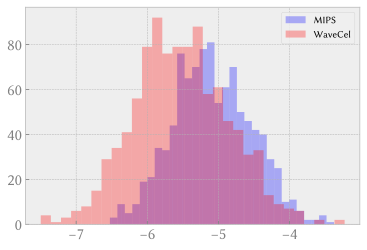

In [18]:
plt.hist(effect_mips, bins=30, label="MIPS", color="blue", alpha=0.3)
plt.hist(effect_wavecel, bins=30, label="WaveCel", color="red", alpha=0.3)
plt.legend();

We can calculate the proportion of bootstrap samples where WaveCel dominates MIPS (ie its performance score is lower, remember that a lower score is better here). 

In [19]:
(effect_wavecel < effect_mips).sum() / float(len(effect_wavecel))

0.816